In [1]:
%%html
<style>
    #notebook-container{
    width: 100%
    }
</style>

In [2]:
import numpy as np #importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stat

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn import model_selection
from scipy import stats

sns.set()

In [3]:
# telco_df = pd.read_csv('telco.txt', sep='\t') #load dataset
telco_df = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Statistic/master/telco.txt', sep='\t') #load dataset
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


# Problem 6: Regression techniques

In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 2. The variable "tenure" is taken as the dependent variable and the remaining variables as explanatory. <br>

## Subtask 1.

The lasso regression is an alternative approach to variable selection. <br>

### Part (a)
Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

### Part (b)

For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i - \bar x)/\hat \sigma_x$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable "ed"?

For Lasso regression scaling of data become crucial because independent variables should be centered around 0 (have mean of 0). Because of this reason we perform scaling of data as per formula $\frac{(x_i - \bar x)}{\hat \sigma_x}$. Without scaling Lasso regression would provide a wrong results - countours of Least Square solution will intersect with non-scaled data in different points than it should. <br>

As for binary variables - those should be scaled as well. Otherwise for such variables like "gender" mean value will be around 0.5 and not 0 as it should be. Same holds for other binary variables - mean value is not equal to 0 as result Lasso regression will produce wrong results. Hence, I am also scaling all dummy variables to center those around mean of 0. <br>

For variable "ed", in addition to scaling, we also need to group all education related dummy variables and perform group Lasso regression which keeps related dummy variables as single group. In such case either none or all of such variables are excluded. Grouped dummy variables could not be excluded partially.

In [4]:
telco_df_norm = telco_df.copy() #normalizing data

telco_df_norm.tenure = (telco_df_norm.tenure-telco_df_norm.tenure.mean()) / telco_df_norm.tenure.std()
telco_df_norm.age = (telco_df_norm.age-telco_df_norm.age.mean()) / telco_df_norm.age.std()
telco_df_norm.address = (telco_df_norm.address-telco_df_norm.address.mean()) / telco_df_norm.address.std()
telco_df_norm.income = (telco_df_norm.income-telco_df_norm.income.mean()) / telco_df_norm.income.std()
telco_df_norm.employ = (telco_df_norm.employ-telco_df_norm.employ.mean()) / telco_df_norm.employ.std()
telco_df_norm.longmon = (telco_df_norm.longmon-telco_df_norm.longmon.mean()) / telco_df_norm.longmon.std()
telco_df_norm.wiremon = (telco_df_norm.wiremon-telco_df_norm.wiremon.mean()) / telco_df_norm.wiremon.std()

telco_df_norm.describe()

,tenure,age,address,income,employ,longmon,wiremon
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00


In [5]:
telco_df_norm_dummy = telco_df_norm.copy()

telco_df_norm_dummy = pd.get_dummies(telco_df_norm, columns=(['marital', 'retire', 'gender', 'churn', 'ed']))

telco_df_norm_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', 
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_norm_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_norm_dummy.marital_dummy = (telco_df_norm_dummy.marital_dummy-telco_df_norm_dummy.marital_dummy.mean()) / telco_df_norm_dummy.marital_dummy.std()
telco_df_norm_dummy.retire_dummy = (telco_df_norm_dummy.retire_dummy-telco_df_norm_dummy.retire_dummy.mean()) / telco_df_norm_dummy.retire_dummy.std()
telco_df_norm_dummy.gender_dummy = (telco_df_norm_dummy.gender_dummy-telco_df_norm_dummy.gender_dummy.mean()) / telco_df_norm_dummy.gender_dummy.std()
telco_df_norm_dummy.churn_dummy = (telco_df_norm_dummy.churn_dummy-telco_df_norm_dummy.churn_dummy.mean()) / telco_df_norm_dummy.churn_dummy.std()
telco_df_norm_dummy.ed_dummy_college_degree = (telco_df_norm_dummy.ed_dummy_college_degree-telco_df_norm_dummy.ed_dummy_college_degree.mean()) / telco_df_norm_dummy.ed_dummy_college_degree.std()
telco_df_norm_dummy.ed_dummy_no_high_school = (telco_df_norm_dummy.ed_dummy_no_high_school-telco_df_norm_dummy.ed_dummy_no_high_school.mean()) / telco_df_norm_dummy.ed_dummy_no_high_school.std()
telco_df_norm_dummy.ed_dummy_high_school = (telco_df_norm_dummy.ed_dummy_high_school-telco_df_norm_dummy.ed_dummy_high_school.mean()) / telco_df_norm_dummy.ed_dummy_high_school.std()
telco_df_norm_dummy.ed_dummy_some_college = (telco_df_norm_dummy.ed_dummy_some_college-telco_df_norm_dummy.ed_dummy_some_college.mean()) / telco_df_norm_dummy.ed_dummy_some_college.std()

telco_df_norm_dummy.describe()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16,9.992007e-17,-1.318390e-16,-2.435829e-16,6.616929e-17,-8.992806e-17,-1.403322e-16,1.296740e-16,1.183498e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01,1.009545e+00,-2.219654e-01,1.034081e+00,1.626956e+00,-5.524288e-01,-5.059893e-01,1.575384e+00,-5.137687e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00,1.009545e+00,4.500702e+00,1.034081e+00,1.626956e+00,1.808378e+00,1.974350e+00,1.575384e+00,1.944455e+00


### Part (c)

Run a lasso regression for data with $\lambda \in (0, 1)$. Plot the estimated parameters as functions of $\lambda$. Which value of $\lambda$ would you recommend? If it is easy to implement, then determine the optimal $\lambda$ by cross-validation.

For alpha=0.9
Training score: 0.0
Test score: -0.020473045785242894
Number of features used: 0 

For alpha=0.5
Training score: 0.27047565337499
Test score: 0.23074914098105268
Number of features used: 1 

For alpha=0.25
Training score: 0.4800080555653707
Test score: 0.44971606433060707
Number of features used: 4 

For alpha=0.1
Training score: 0.5695920578733327
Test score: 0.5684739772606409
Number of features used: 6 

For alpha=0.01
Training score: 0.617172833267151
Test score: 0.6130039241971024
Number of features used: 11 

For alpha=0.001
Training score: 0.6187817718279505
Test score: 0.6125617717254648
Number of features used: 14 

For alpha=0.0001
Training score: 0.618852390575082
Test score: 0.6128354457522676
Number of features used: 14 



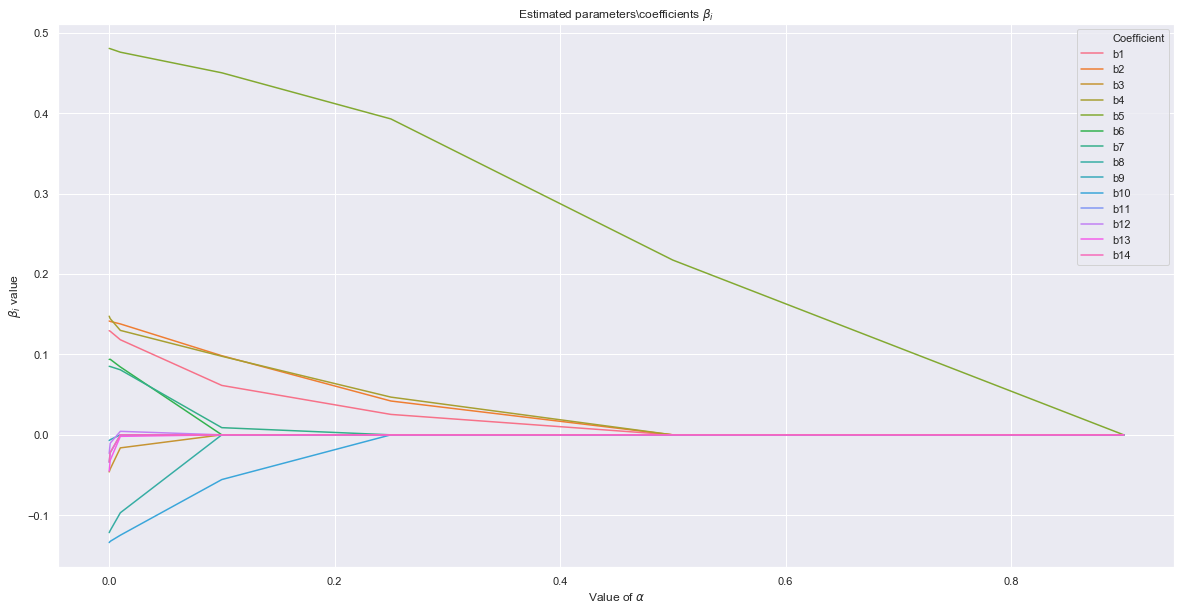

In [51]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

lambdas = [0.9, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001]
coefficients = []

for lambd in lambdas:
    X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X,Y, test_size=0.3, random_state=7)

    lasso = linear_model.Lasso(alpha=lambd, max_iter=10e5)
    lasso.fit(X_train,Y_train)
    train_score=lasso.score(X_train,Y_train)
    test_score=lasso.score(X_test,Y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    coefficients.append(lasso.coef_)

    print("For alpha=%s" %lambd)
    print("Training score: %s" %train_score )
    print("Test score: %s" %test_score)
    print("Number of features used: %s \n" %coeff_used)
    

coefficients_df = pd.DataFrame(coefficients, columns=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b13", "b14"])
coefficients_df['alpha'] = lambdas
# coefficients_df = coefficients_df.unstack()
# coefficients_df = pd.DataFrame(coefficients_df)
coefficients_df = coefficients_df.melt(id_vars=['alpha'], var_name='Coefficient')
coefficients_df.tail()

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="alpha", y="value", hue="Coefficient", data=coefficients_df, )
# sns.lineplot(x=alphas, y="b2", data=coefficients_df)
# sns.lineplot(x=alphas, y="b3", data=coefficients_df)
plt.title("Estimated parameters\coefficients $\\beta_i$")
plt.ylabel("$\\beta_i$ value")
plt.xlabel("Value of $\\alpha$")
plt.show()